In [1]:
import os
import pandas as pd
import requests
import time
import json
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.formula.api as smf
import seaborn as sns 

from sklearn.cross_decomposition import PLSRegression
from pygam import LinearGAM, s
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from statsmodels.stats.multitest import multipletests
from scipy.stats import gaussian_kde 

In [2]:
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")


# THIS pulls sector and subsector info either localy if it's cached or from the api

API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"

# --- LOAD FROM CACHE OR FETCH ---
if os.path.exists(tickers_csv_file):
    print("Loading tickers from CSV cache...")
    df_sp500 = pd.read_csv(tickers_csv_file)
else:
    print("Fetching tickers from API...")
    url = f"https://financialmodelingprep.com/api/v3/sp500_constituent?apikey={API_KEY}"
    df_sp500 = pd.DataFrame(requests.get(url).json())

    # Save to CSV
    df_sp500.to_csv(tickers_csv_file, index=False)
    print(f"Saved {len(df_sp500)} tickers to CSV cache.")

    
# --- PREVIEW ---
print(df_sp500.shape)
print(df_sp500.columns)

Loading tickers from CSV cache...
(503, 8)
Index(['symbol', 'name', 'sector', 'subSector', 'headQuarter',
       'dateFirstAdded', 'cik', 'founded'],
      dtype='object')


In [3]:
tickers = df_sp500["symbol"].dropna().unique().tolist()

In [4]:
API_KEY = "YwnbHRjcJvf6Md2OPoKbSRGHlzZ7hjR6"
data_folder = os.path.join(os.path.expanduser("~/Desktop/Trading"), "Data")
os.makedirs(data_folder, exist_ok=True)
tickers_csv_file = os.path.join(data_folder, "sp500_tickers.csv")

# Load tickers
df_sp500 = pd.read_csv(tickers_csv_file)
tickers = df_sp500["symbol"].dropna().unique().tolist()

# Output file
output_file = os.path.join(data_folder, "price_and_earnings.json")

def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))


def fetch_price_and_earnings(tickers, output_file):
    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        return pd.DataFrame(json.load(open(output_file)))

    records = []
    for ticker in tickers:
        try:
            # Get current price
            quote_url = f"https://financialmodelingprep.com/api/v3/quote/{ticker}?apikey={API_KEY}"
            price_data = requests.get(quote_url).json()
            if not price_data:
                continue
            price = price_data[0]["price"]
            price_date = price_data[0].get("date")  # trading date

            # Get latest annual income statement
            income_url = f"https://financialmodelingprep.com/api/v3/income-statement/{ticker}?limit=1&apikey={API_KEY}"
            income_data = requests.get(income_url).json()
            if not income_data:
                continue
            eps = income_data[0].get("eps")
            net_income = income_data[0].get("netIncome")
            report_date = income_data[0].get("date")  # fiscal period end date

            records.append({
                "symbol": ticker,
                "price": price,
                "eps": eps,
                "date": report_date
            })

        except Exception as e:
            print(f"Error fetching {ticker}: {e}")
        time.sleep(0.2)  # polite rate limit

    # Save to JSON
    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")

    return pd.DataFrame(records)


price_earnings_df = fetch_price_and_earnings(tickers, output_file)
print(price_earnings_df.columns)
price_earnings_df.head(15)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/price_and_earnings.json
Index(['symbol', 'price', 'price_date', 'eps', 'netIncome', 'date'], dtype='object')


,symbol,price,price_date,eps,netIncome,date
0,XYZ,76.81,None,4.70,2897047000,2024-12-31
1,TTD,50.88,None,0.80,393076000,2024-12-31
2,DDOG,151.57,None,0.55,183746000,2024-12-31
3,COIN,372.07,None,10.42,2579066000,2024-12-31
4,DASH,270.09,None,0.30,123000000,2024-12-31
5,EXE,107.86,None,-4.55,-714000000,2024-12-31
6,TKO,198.00,None,0.12,9408000,2024-12-31
7,WSM,196.14,None,8.91,1125251000,2025-02-02
8,APO,127.23,None,7.39,4426000000,2024-12-31
9,LII,546.61,None,22.67,806900000,2024-12-31


In [5]:
#CLEANS AND TAKES LOG OF THE PE DATA

# Only keep rows with positive EPS
pe_data = price_earnings_df[price_earnings_df["eps"] > 0].copy()

# Compute log(PE)
pe_data["log_PE"] = np.log(pe_data["price"] / pe_data["eps"])

# Print row count for reference
print(pe_data.shape)

(480, 7)


In [6]:
# FETCHES INCOME STATEMENT AND BS STATEMENT AND CF STATEMENT
def fetch_statement(endpoint, tickers, period, limit, data_folder):
    """Fetch statements with unique JSON filename based on endpoint, period, limit."""
    output_file = os.path.join(
        data_folder,
        f"{endpoint}_{period}_limit{limit}.json"
    )

    if os.path.exists(output_file):
        print(f"Loading from cache: {output_file}")
        with open(output_file, "r") as f:
            return json.load(f)

    records = []
    for ticker in tickers:
        url = f"https://financialmodelingprep.com/api/v3/{endpoint}/{ticker}?period={period}&limit={limit}&apikey={API_KEY}"
        try:
            response = requests.get(url)
            response.raise_for_status()
            data = response.json()
            if data:
                for row in data:
                    row["symbol"] = ticker
                records.extend(data)
        except Exception as e:
            print(f"Error fetching {ticker} ({endpoint}): {e}")
        time.sleep(.2)  # API polite rate limit

    with open(output_file, "w") as f:
        json.dump(records, f, indent=2)
    print(f"Saved {len(records)} records to {output_file}")
    # "RECORDS HERE IS A LIST OF STRINGS NOT A DF"
    return records

# AT THIS POINT INCOME_DATA_2_YEARS IS STILL A LIST OF STRINGS STORED AS A VAR
income_data_2_years   = fetch_statement("income-statement", tickers, "annual", 2, data_folder)
balance_data_2_years  = fetch_statement("balance-sheet-statement", tickers, "annual", 2, data_folder)
cashflow_data_2_years = fetch_statement("cash-flow-statement", tickers, "annual", 2, data_folder)

# INCOME_DATA_2_YEARS IS CONVERTED TO A DF
income_data_2_years   = pd.DataFrame(income_data_2_years)
balance_data_2_years  = pd.DataFrame(balance_data_2_years)
cashflow_data_2_years = pd.DataFrame(cashflow_data_2_years)

print("Income shape:", income_data_2_years.shape)
print("Balance shape:", balance_data_2_years.shape)
print("Cash flow shape:", cashflow_data_2_years.shape)

Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/income-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/balance-sheet-statement_annual_limit2.json
Loading from cache: /Users/nicholassanso/Desktop/Trading/Data/cash-flow-statement_annual_limit2.json
Income shape: (1006, 38)
Balance shape: (1006, 54)
Cash flow shape: (1006, 40)


# End of fetching

In [7]:
cols_to_drop_income = [
    "netIncome", "netIncomeRatio", "epsdiluted", "eps",
    "operatingIncomeRatio", "incomeBeforeTaxRatio",
    "incomeBeforeTax", "operatingIncome","ebitda","ebitdaratio", "link", "finalLink","fillingDate","cik",
    "acceptedDate","reportedCurrency","period","calendarYear"]

cols_to_drop_balance = [
    "eps","retainedEarnings", "totalStockholdersEquity","othertotalStockholdersEquity", "totalEquity", 
    "link", "finalLink","fillingDate","cik","acceptedDate","reportedCurrency","period","calendarYear"]

cols_to_drop_cashflow = [
    "eps", "link", "finalLink","fillingDate","operatingCashFlow", "netCashProvidedByOperatingActivities",
    "cik","acceptedDate","netIncome","reportedCurrency","period","calendarYear"]

cols_to_drop_pe = ["eps","price","netIncome"]

income_data_2_years = income_data_2_years.drop(columns=cols_to_drop_income, errors="ignore")
balance_data_2_years = balance_data_2_years.drop(columns=cols_to_drop_balance, errors="ignore")
cashflow_data_2_years = cashflow_data_2_years.drop(columns=cols_to_drop_cashflow, errors="ignore")
pe_data = pe_data.drop(columns=cols_to_drop_pe, errors="ignore")

In [8]:
print(income_data_2_years.columns.tolist)
print(balance_data_2_years.columns.tolist)
print(cashflow_data_2_years.columns.tolist)
print(pe_data.columns.tolist)

<bound method IndexOpsMixin.tolist of Index(['date', 'symbol', 'revenue', 'costOfRevenue', 'grossProfit',
       'grossProfitRatio', 'researchAndDevelopmentExpenses',
       'generalAndAdministrativeExpenses', 'sellingAndMarketingExpenses',
       'sellingGeneralAndAdministrativeExpenses', 'otherExpenses',
       'operatingExpenses', 'costAndExpenses', 'interestIncome',
       'interestExpense', 'depreciationAndAmortization',
       'totalOtherIncomeExpensesNet', 'incomeTaxExpense',
       'weightedAverageShsOut', 'weightedAverageShsOutDil'],
      dtype='object')>
<bound method IndexOpsMixin.tolist of Index(['date', 'symbol', 'cashAndCashEquivalents', 'shortTermInvestments',
       'cashAndShortTermInvestments', 'netReceivables', 'inventory',
       'otherCurrentAssets', 'totalCurrentAssets', 'propertyPlantEquipmentNet',
       'goodwill', 'intangibleAssets', 'goodwillAndIntangibleAssets',
       'longTermInvestments', 'taxAssets', 'otherNonCurrentAssets',
       'totalNonCurrentAsset

In [9]:
# --- Clean up column names (remove spaces, tabs, and backslashes) ---
for df_name, df in {
    "income_data_2_years": income_data_2_years,
    "balance_data_2_years": balance_data_2_years,
    "cashflow_data_2_years": cashflow_data_2_years,
    "pe_data": pe_data
}.items():
    df.columns = df.columns.str.strip().str.replace(r'\\', '', regex=True)
    print(f"{df_name}: cleaned column names")


income_data_2_years: cleaned column names
balance_data_2_years: cleaned column names
cashflow_data_2_years: cleaned column names
pe_data: cleaned column names


In [10]:
def count_problematic_entries(df, label):
    print(f"\n🔍 Problematic value counts for {label} statement:")
    
    def count_issues(col):
        numeric_col = pd.to_numeric(col, errors='coerce')
        return ((numeric_col.isna()) | (numeric_col == 0)).sum()

    issue_counts = df.apply(count_issues)
    filtered_counts = issue_counts[issue_counts > 0].sort_values()
    print(filtered_counts)


In [11]:
count_problematic_entries(income_data_2_years, "Income")
count_problematic_entries(balance_data_2_years, "Balance Sheet")
count_problematic_entries(cashflow_data_2_years, "Cash Flow")


🔍 Problematic value counts for Income statement:
operatingExpenses                             8
depreciationAndAmortization                   9
incomeTaxExpense                             12
costOfRevenue                                20
interestExpense                              63
totalOtherIncomeExpensesNet                  65
sellingGeneralAndAdministrativeExpenses      79
otherExpenses                               330
interestIncome                              352
generalAndAdministrativeExpenses            548
researchAndDevelopmentExpenses              605
sellingAndMarketingExpenses                 727
date                                       1006
symbol                                     1006
dtype: int64

🔍 Problematic value counts for Balance Sheet statement:
totalNonCurrentAssets                         2
totalNonCurrentLiabilities                    4
totalDebt                                     5
totalCurrentAssets                            5
otherNonCurrentA

In [12]:
def sort_by_symbol_then_date(df):
    # Sort ascending by symbol, then by date (oldest first)
    return df.sort_values(["symbol", "date"], ascending=[True, True]).reset_index(drop=True)


income_sorted = sort_by_symbol_then_date(income_data_2_years)
balance_sorted = sort_by_symbol_then_date(balance_data_2_years)
cashflow_sorted = sort_by_symbol_then_date(cashflow_data_2_years)
pe_data_sorted = sort_by_symbol_then_date(pe_data)


pe_data_sorted.head(8)

,symbol,price_date,date,log_PE
0,A,None,2024-10-31,3.441659
1,AAPL,None,2024-09-28,3.739655
2,ABBV,None,2024-12-31,4.590733
3,ABNB,None,2024-12-31,3.367131
4,ABT,None,2024-12-31,2.852957
5,ACGL,None,2024-12-31,2.049800
6,ACN,None,2025-08-31,2.989775
7,ADBE,None,2024-11-29,3.341236


In [13]:
#DOUBLE CHECK THE ECISION TO ADD A CONSTANT... ELONGATING THE TAIL OF THE DISTRIBUTION
# DATA PROVIDER PUTS "0" FOR ANY LINE ITEM THAT DOESN'T EXIST IN THE FINANCIAL STATEMENT... ADDING THE CONSTANT THEN RETURNS A SMALL VALUE WHICH IN TURN 
#ALLOWS FOR A HUGE LOG CHANGE OUTLIER IF THAT LINE ITEM IN THE NEXT FINANCIALS STATEMENT IS ANYHTING OTHER THAN 0?

def compute_log_change(df, constant=1e-3, drop_first=True):
    """
    Compute log-differences for year-over-year growth of financial statement items.
    retains 'symbol' and 'date' columns.

    Parameters
    ----------
    df : pd.DataFrame
        Must include 'symbol' and 'date' columns, sorted by both.
    constant : float
        Small stabilizing constant for log transform.
    drop_first : bool
        Whether to drop the first row per symbol (NaN after diff).
    """
    df = df.copy()
    # Numeric part
    num_df = df.select_dtypes(include=[np.number])
    log_df = np.log(np.abs(num_df) + constant)
    log_diff = log_df.diff()

    # Rename to show log-change
    log_diff.columns = [f"{col}_logchg" for col in log_diff.columns]

    # Combine with non-numeric columns
    result = pd.concat([df[["symbol", "date"]], log_diff], axis=1)

    if drop_first:
        # Drop the first row per symbol (which has NaN diffs)
        result = result.groupby("symbol", group_keys=False).apply(lambda g: g.iloc[1:])

    return result.reset_index(drop=True)


# --- Apply grouped by symbol ---
income_log_change = (
    income_sorted.groupby("symbol", group_keys=False)
    .apply(lambda g: compute_log_change(g))
)

balance_log_change = (
    balance_sorted.groupby("symbol", group_keys=False)
    .apply(lambda g: compute_log_change(g))
)

cashflow_log_change = (
    cashflow_sorted.groupby("symbol", group_keys=False)
    .apply(lambda g: compute_log_change(g))
)



In [14]:
def count_zeros_nans_logchg(df):
    # Keep only numeric columns that end with "_logchg"
    numeric_cols = [c for c in df.select_dtypes(include=[float, int]).columns if c.endswith("_logchg")]
    
    # Count zeros and NaNs
    zero_counts = (df[numeric_cols] == 0).sum()
    nan_counts = df[numeric_cols].isna().sum()
    
    # Combine into a single DataFrame
    summary = pd.DataFrame({
        "zeros": zero_counts,
        "nans": nan_counts
    }).sort_values(by=["zeros", "nans"], ascending=True)
    
    # Force full display
    with pd.option_context("display.max_rows", None, "display.max_columns", None):
        print(summary)
    
    return summary

# Example usage
print("Income 0/NaN counts per YoY column:")
income_summary = count_zeros_nans_logchg(income_log_change)

print("\nBalance 0/NaN counts per YoY column:")
balance_summary = count_zeros_nans_logchg(balance_log_change)

print("\nCashflow 0/NaN counts per YoY column:")
cashflow_summary = count_zeros_nans_logchg(cashflow_log_change)

# the purpose here is to make it easy to identify which line items (columns) are fully filled out from our sample so that we are only grabbing columns (features)
# that are likely to be filled out by the stock under consideration, cause ultimately after we find a regression that has explanatory power... we can still only apply it 
# to the stock under consideration if it has the same line items filled out 
# the 503 nans is a result of the .pct change method that we used which creates a nan on every other row

Income 0/NaN counts per YoY column:
                                                zeros  nans
revenue_logchg                                      0     0
grossProfit_logchg                                  0     0
costAndExpenses_logchg                              0     0
operatingExpenses_logchg                            4     0
depreciationAndAmortization_logchg                  5     0
costOfRevenue_logchg                                7     0
incomeTaxExpense_logchg                             7     0
weightedAverageShsOut_logchg                        7     0
grossProfitRatio_logchg                            10     0
weightedAverageShsOutDil_logchg                    10     0
totalOtherIncomeExpensesNet_logchg                 32     0
sellingGeneralAndAdministrativeExpenses_logchg     34     0
interestExpense_logchg                             35     0
otherExpenses_logchg                              137     0
interestIncome_logchg                             169     0
gene

In [15]:
def add_symbol_date_column(df):
    """
    Adds a 'symbol_date' column to the input DataFrame.
    
    Parameters:
    df : pandas.DataFrame
        A DataFrame with 'symbol' and 'date' columns.
    
    Returns:
    pandas.DataFrame
        A new DataFrame with the added 'symbol_date' column.
    """
    df_copy = df.copy()
    df_copy["symbol_date"] = list(zip(df_copy["symbol"], df_copy["date"]))
    return df_copy


In [16]:
income_symbol_date_added = add_symbol_date_column(income_log_change)
balance_symbol_date_added = add_symbol_date_column(balance_log_change)
cashflow_symbol_date_added = add_symbol_date_column(cashflow_log_change)
pe_data_sorted = add_symbol_date_column(pe_data_sorted)

In [17]:
common_pairs = (
    set(income_symbol_date_added["symbol_date"])
    & set(balance_symbol_date_added["symbol_date"])
    & set(cashflow_symbol_date_added["symbol_date"])
    & set(pe_data_sorted["symbol_date"])
)

In [18]:
def filter_by_common_pairs(df, common_pairs):
    """
    Keep only rows where the 'symbol_date' is in common_pairs.
    Returns a new DataFrame.
    """
    return df[df["symbol_date"].isin(common_pairs)].copy()

income_post_nans_overlapped = filter_by_common_pairs(income_symbol_date_added, common_pairs)
balance_post_nans_overlapped = filter_by_common_pairs(balance_symbol_date_added, common_pairs)
cashflow_post_nans_overlapped = filter_by_common_pairs(cashflow_symbol_date_added, common_pairs)
pe_post_nans_overlapped = filter_by_common_pairs(pe_data_sorted, common_pairs)

print(income_post_nans_overlapped.shape)
print(balance_post_nans_overlapped.shape)
print(cashflow_post_nans_overlapped.shape)
print(pe_post_nans_overlapped.shape)

# we only want to include a ticker if we have all the financial statement items for all dataframes

(479, 21)
(479, 43)
(479, 30)
(479, 5)


In [19]:
# Step 2: Sort consistently
income_post_nans_overlapped = income_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
balance_post_nans_overlapped = balance_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
cashflow_post_nans_overlapped = cashflow_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)
pe_post_nans_overlapped = pe_post_nans_overlapped.sort_values(["symbol", "date"]).reset_index(drop=True)


print(
    "Cleaned and aligned shapes:", 
    income_post_nans_overlapped.shape,   
    balance_post_nans_overlapped.shape, 
    cashflow_post_nans_overlapped.shape,
    pe_post_nans_overlapped.shape,
)

Cleaned and aligned shapes: (479, 21) (479, 43) (479, 30) (479, 5)


In [20]:
def check_alignment(dfs: dict):
    """
    Check alignment of multiple DataFrames on 'symbol' and 'date'.
    Expects each DataFrame to have the same row order and columns: 'symbol', 'date'.
    
    Parameters
    
    None (prints summary of mismatches)
    """
    # Ensure equal lengths
    lengths = {name: len(df) for name, df in dfs.items()}
    if len(set(lengths.values())) > 1:
        print("⚠️ Row counts differ between DataFrames:")
        for name, length in lengths.items():
            print(f"  {name}: {length} rows")
    else:
        print(f"✅ All DataFrames have {list(lengths.values())[0]} rows")

    # Concatenate for comparison
    merged = pd.concat(
        {name: df[["symbol", "date"]].reset_index(drop=True) for name, df in dfs.items()},
        axis=1
    )

    # Compare across DataFrames
    base = list(dfs.keys())[0]  # pick first as reference
    symbol_mismatches = 0
    date_mismatches = 0

    for i in range(len(dfs[base])):
        symbols = [merged[(name, "symbol")][i] for name in dfs.keys()]
        dates   = [merged[(name, "date")][i]   for name in dfs.keys()]
        if len(set(symbols)) > 1:
            symbol_mismatches += 1
        if len(set(dates)) > 1:
            date_mismatches += 1

    print(f"Symbol mismatches: {symbol_mismatches}")
    print(f"Date mismatches:   {date_mismatches}")

    
check_alignment({
    "income": income_post_nans_overlapped,
    "balance": balance_post_nans_overlapped,
    "cashflow": cashflow_post_nans_overlapped,
    "pe": pe_post_nans_overlapped
})

✅ All DataFrames have 479 rows
Symbol mismatches: 0
Date mismatches:   0


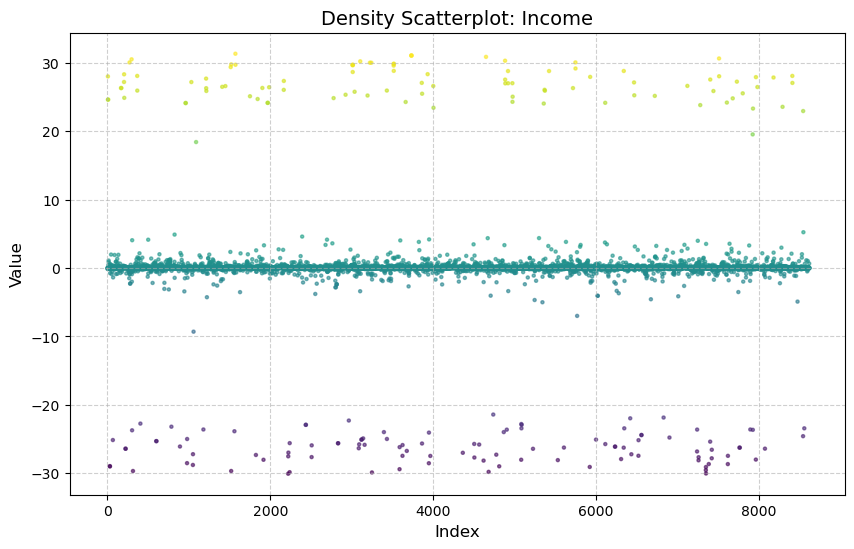

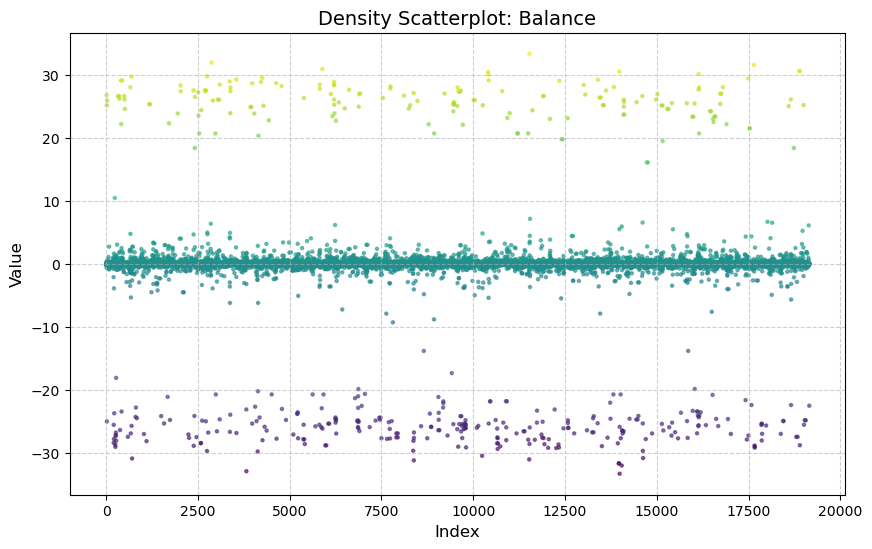

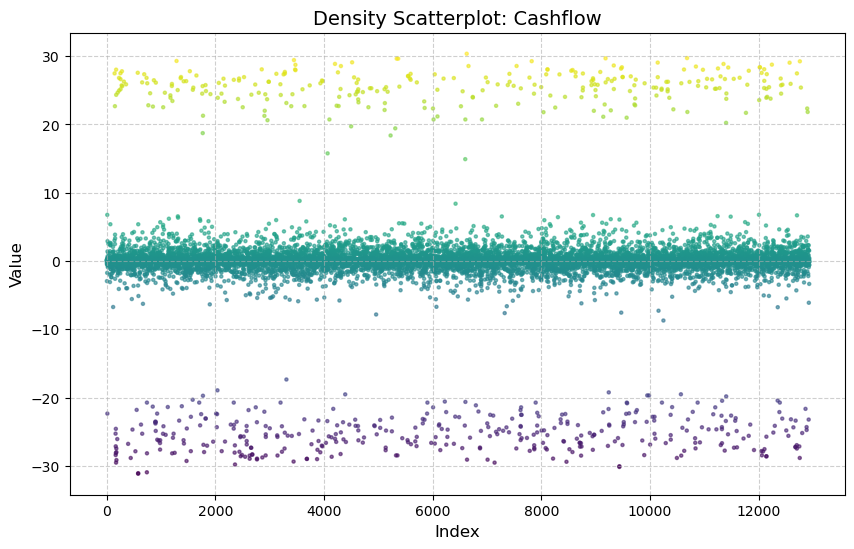

In [21]:
def outlier_check_1(df, title):
    # Flatten all numeric columns into one long vector
    numeric_cols = df.select_dtypes(include=["float", "int"]).columns
    values = df[numeric_cols].values.flatten()
    values = values[~np.isnan(values)]  # drop NaNs

    # Scatter vs. index, colored by density
    plt.figure(figsize=(10, 6))
    sns.kdeplot(values, fill=True, color="lightblue", alpha=0.3, linewidth=0)  # background density
    plt.scatter(range(len(values)), values, 
                c=values, cmap="viridis", s=5, alpha=0.6)

    plt.title(f"Density Scatterplot: {title}", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Value", fontsize=12)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

# Call for each of your cleaned DataFrames
outlier_check_1(income_post_nans_overlapped, "Income")
outlier_check_1(balance_post_nans_overlapped, "Balance")
outlier_check_1(cashflow_post_nans_overlapped, "Cashflow")

#demonstrates the necessity for addressing outlier concerns 
# ONLY PURPOSE OF. THIS IS TO CONFIRM WE HAVE SERIOUS OUTLIERS THAT NEED TO BE ADDRESSED

In [22]:
def drop_high_zero_columns(df, threshold=0.05):
    """
    Drops columns with more than `threshold` proportion of zero values,
    and reports how many columns were dropped.
    """
    original_col_count = df.shape[1]

    zero_proportion = (df == 0).sum() / len(df)
    cols_to_drop = zero_proportion[zero_proportion > threshold].index

    df = df.drop(columns=cols_to_drop)
    new_col_count = df.shape[1]

    print(f"Columns before: {original_col_count}")
    print(f"Columns dropped: {len(cols_to_drop)} (>{threshold*100:.1f}% zeros)")
    print(f"Columns after: {new_col_count}")

    return df

Columns before: 20
Columns dropped: 8 (>5.0% zeros)
Columns after: 12
Columns before: 42
Columns dropped: 21 (>5.0% zeros)
Columns after: 21
Columns before: 29
Columns dropped: 15 (>5.0% zeros)
Columns after: 14


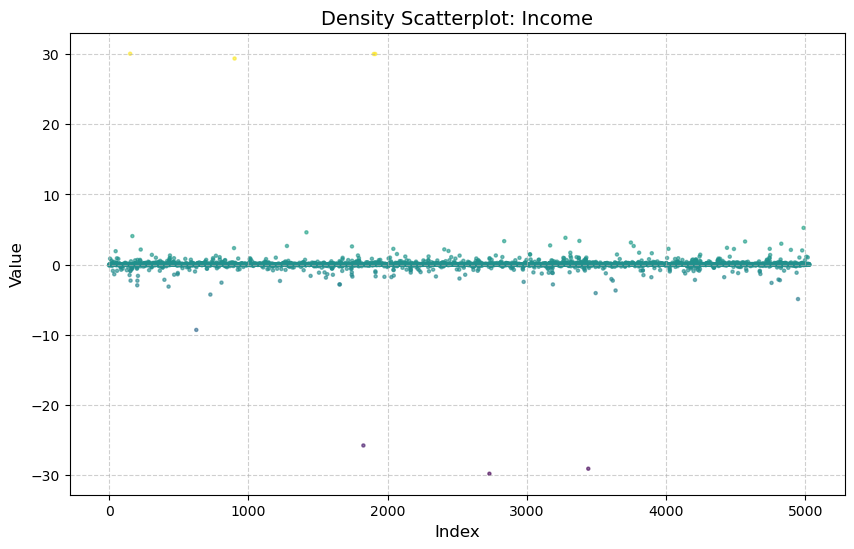

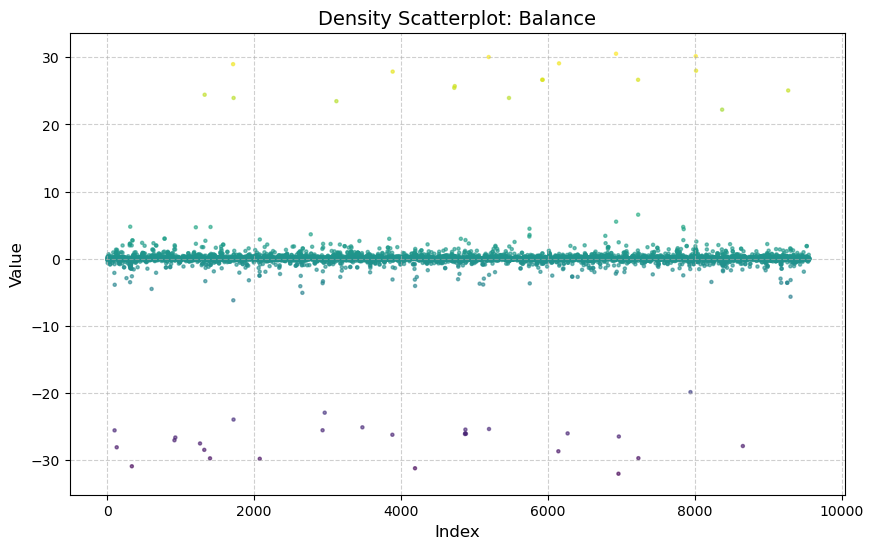

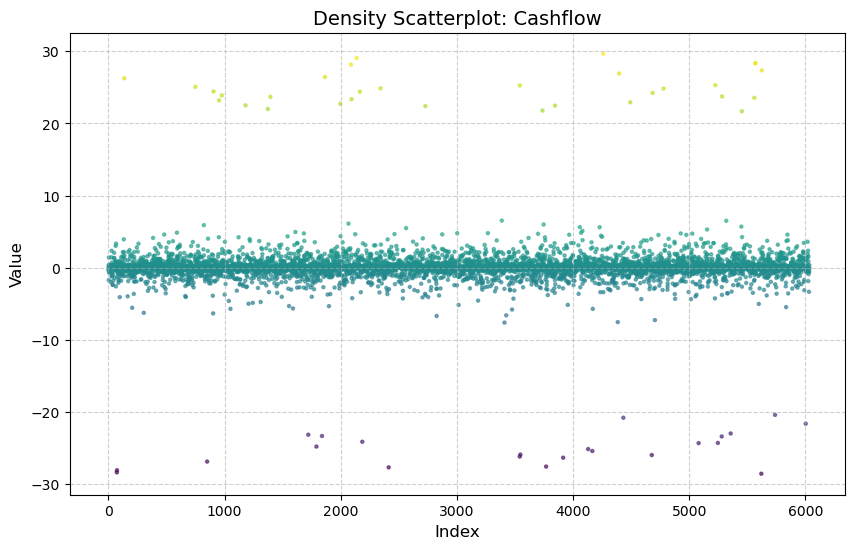

(503, 12)
(503, 21)
(503, 14)


In [23]:
income_after_feature_drop = drop_high_zero_columns(income_log_change, threshold=0.05)
balance_after_feature_drop = drop_high_zero_columns(balance_log_change, threshold=0.05)
cashflow_after_feature_drop = drop_high_zero_columns(cashflow_log_change, threshold=0.05)

# Call for each of your cleaned DataFrames
outlier_check_1(income_after_feature_drop, "Income")
outlier_check_1(balance_after_feature_drop, "Balance")
outlier_check_1(cashflow_after_feature_drop, "Cashflow")

print(income_after_feature_drop.shape)
print(balance_after_feature_drop.shape)
print(cashflow_after_feature_drop.shape)

In [24]:
def drop_outlier_rows(df, threshold=10):
    """
    Drops rows where ANY numeric column has a value greater than `threshold`
    or less than `-threshold`. Prints how many rows remain afterward.

    Parameters
    ----------
    df : pd.DataFrame
        The dataframe to filter.
    threshold : float
        Absolute cutoff for detecting outliers (e.g., 10 retains rows within [-10, 10]).
    """
    original_row_count = df.shape[0]

    # Identify numeric columns
    numeric_cols = df.select_dtypes(include=["number"]).columns

    # Create mask: keep rows where all numeric values are within [-threshold, threshold]
    mask = (df[numeric_cols].abs() <= threshold).all(axis=1)
    df_filtered = df[mask].copy()

    new_row_count = df_filtered.shape[0]
    dropped_rows = original_row_count - new_row_count

    print(f"Rows before: {original_row_count}")
    print(f"Rows dropped: {dropped_rows} (>|{threshold}| in any numeric column)")
    print(f"Rows after: {new_row_count}")

    return df_filtered

Rows before: 503
Rows dropped: 7 (>|10| in any numeric column)
Rows after: 496
Rows before: 503
Rows dropped: 30 (>|10| in any numeric column)
Rows after: 473
Rows before: 503
Rows dropped: 47 (>|10| in any numeric column)
Rows after: 456


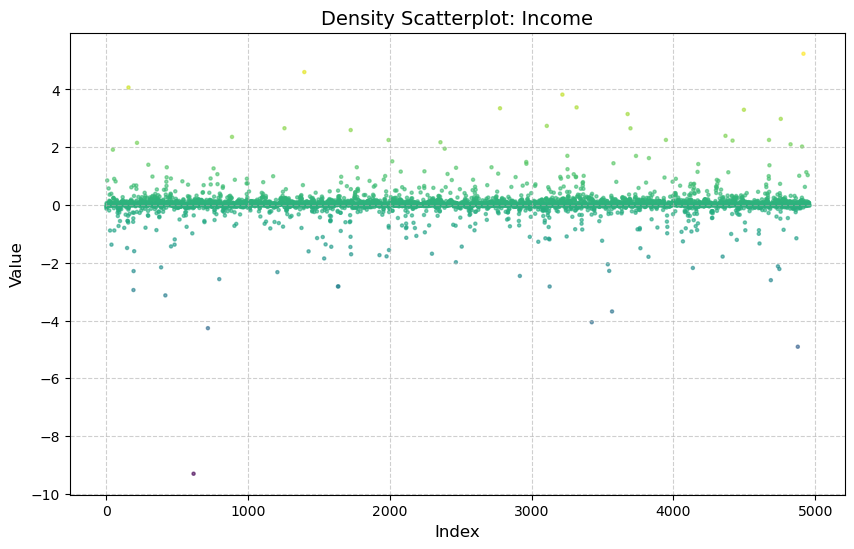

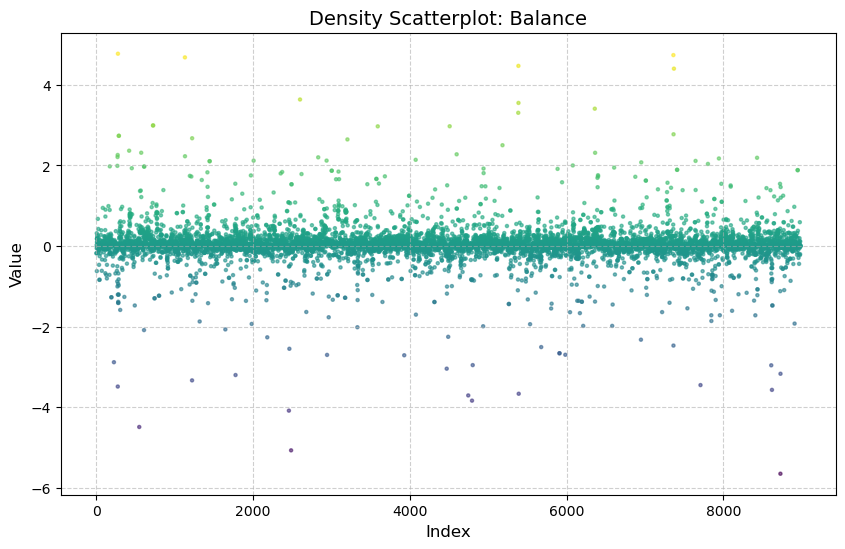

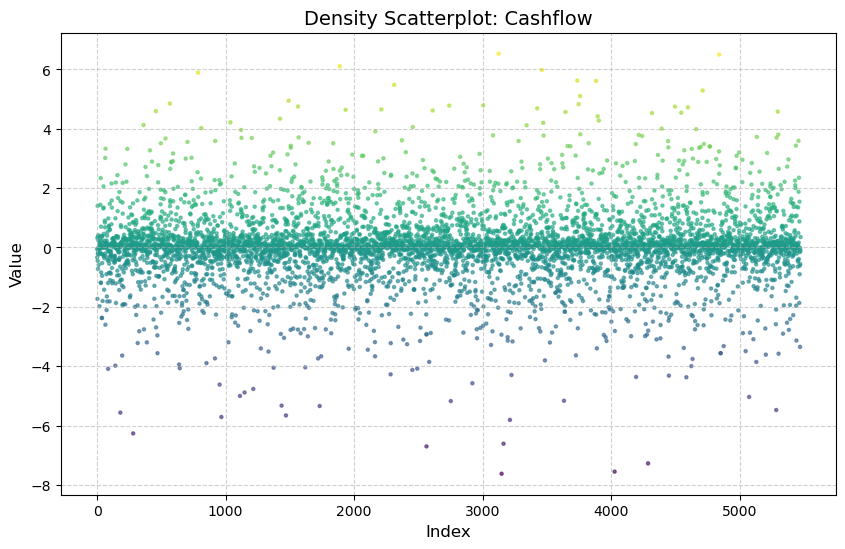

(496, 12)
(473, 21)
(456, 14)


(480, 5)

In [25]:
# --- Drop rows with extreme outliers (values beyond ±10) ---
income_after_outlier_drop   = drop_outlier_rows(income_after_feature_drop, threshold=10)
balance_after_outlier_drop  = drop_outlier_rows(balance_after_feature_drop, threshold=10)
cashflow_after_outlier_drop = drop_outlier_rows(cashflow_after_feature_drop, threshold=10)

outlier_check_1(income_after_outlier_drop, "Income")
outlier_check_1(balance_after_outlier_drop, "Balance")
outlier_check_1(cashflow_after_outlier_drop, "Cashflow")


print(income_after_outlier_drop.shape)
print(balance_after_outlier_drop.shape)
print(cashflow_after_outlier_drop.shape)
pe_data_sorted.shape

In [26]:
### YOU MUST REALIGN HERE

In [27]:

def align_dfs_on_symbol_date(
    dfs,
    symbol_col="symbol",
    date_col="date",
    key_col="symbol_date",
    drop_duplicates=True,
    verbose=True
):
    """
    Align multiple DataFrames on the intersection of (symbol, date) pairs.

    Parameters
    ----------
    dfs : dict or list
        If dict: mapping name -> DataFrame. 
        If list: list of DataFrames (names will be auto-generated).
    symbol_col : str
        Column name holding the ticker/symbol.
    date_col : str
        Column name holding the date.
    key_col : str
        Name to use for the composite key column.
    drop_duplicates : bool
        If True, drop duplicate key values in each DataFrame (keep first).
    verbose : bool
        Print progress and shapes.

    Returns
    -------
    aligned : dict
        Mapping name -> aligned DataFrame (index set to key_col, but also keeps it as a column).
    common_keys : list
        Sorted list of common key strings present in every DataFrame.

    Raises
    ------
    ValueError if no common keys are found or if required columns are missing.
    """

    # Normalize input to a dict
    if isinstance(dfs, dict):
        df_map = dict(dfs)
    else:
        df_map = {f"df_{i}": df for i, df in enumerate(dfs, 1)}

    # --- 1. Ensure required columns exist and build standardized key strings ---
    for name, df in df_map.items():
        if symbol_col not in df.columns or date_col not in df.columns:
            raise ValueError(f"{name} is missing required columns '{symbol_col}' or '{date_col}'")

        df = df.copy()
        df[key_col] = df[symbol_col].astype(str) + "_" + df[date_col].astype(str)

        if drop_duplicates:
            dup_count = df[key_col].duplicated().sum()
            if dup_count and verbose:
                print(f"{name}: dropping {dup_count} duplicate {key_col} rows (keeping first)")
            df = df[~df[key_col].duplicated(keep="first")]

        df_map[name] = df

    # --- 2. Compute intersection of keys ---
    key_sets = [set(df[key_col]) for df in df_map.values()]
    common = set.intersection(*key_sets) if key_sets else set()

    if not common:
        raise ValueError("No common symbol_date keys found across all DataFrames.")

    common_sorted = sorted(common)  # stable order

    # --- 3. Filter each df to the common keys and align them ---
    aligned = {}
    if verbose:
        print(f"\nCommon observation count: {len(common_sorted)}")

    for name, df in df_map.items():
        before = df.shape[0]
        df_f = df[df[key_col].isin(common)].copy()
        df_f = df_f.set_index(key_col).loc[common_sorted].reset_index()  # <-- keeps symbol_date as column
        after = df_f.shape[0]
        aligned[name] = df_f
        if verbose:
            print(f"  {name}: before={before}, after={after}")

    # --- 4. Sanity check: all have same ordering ---
    first_index = aligned[list(aligned.keys())[0]]["symbol_date"].tolist()
    for name, df in aligned.items():
        assert df["symbol_date"].tolist() == first_index, f"{name} misaligned!"

    return aligned, common_sorted


In [28]:
dfs = {
    "income": income_after_outlier_drop,
    "balance": balance_after_outlier_drop,
    "cashflow": cashflow_after_outlier_drop,
    "pe": pe_data_sorted
}

aligned_dict, common_keys = align_dfs_on_symbol_date(dfs,
                                                     symbol_col="symbol",
                                                     date_col="date",
                                                     key_col="symbol_date",
                                                     drop_duplicates=True,
                                                     verbose=True)

# Access aligned frames:
income_aligned = aligned_dict["income"]
balance_aligned = aligned_dict["balance"]
cashflow_aligned = aligned_dict["cashflow"]
pe_aligned = aligned_dict["pe"]

# Confirm shapes are identical:
print(income_aligned.shape, balance_aligned.shape, cashflow_aligned.shape, pe_aligned.shape)
income_aligned.columns.tolist


Common observation count: 408
  income: before=496, after=408
  balance: before=473, after=408
  cashflow: before=456, after=408
  pe: before=480, after=408
(408, 13) (408, 22) (408, 15) (408, 5)


<bound method IndexOpsMixin.tolist of Index(['symbol_date', 'symbol', 'date', 'revenue_logchg',
       'costOfRevenue_logchg', 'grossProfit_logchg', 'grossProfitRatio_logchg',
       'operatingExpenses_logchg', 'costAndExpenses_logchg',
       'depreciationAndAmortization_logchg', 'incomeTaxExpense_logchg',
       'weightedAverageShsOut_logchg', 'weightedAverageShsOutDil_logchg'],
      dtype='object')>

In [29]:
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro

def run_statement_univariate(statement_df, pe_data_sorted, label="", plot=False):
    # Merge on all three identifier columns to preserve them
    merged = statement_df.merge(
        pe_data_sorted, 
        on=["symbol", "date", "symbol_date"], 
        how="inner"
    )

    X = merged.select_dtypes(include=["number"]).drop(columns=["log_PE"])
    y = merged["log_PE"]

    results = []
    for col in X.columns:
        X_var = sm.add_constant(X[col])
        model = sm.OLS(y, X_var, missing="drop").fit()
        residuals = model.resid
        fitted = model.fittedvalues

        bp_test = het_breuschpagan(residuals, X_var)
        bp_pvalue = bp_test[1]
        shapiro_pvalue = shapiro(residuals)[1] if len(residuals) < 5000 else None

        results.append({
            "feature": col,
            "coef": model.params[col],
            "t_value": model.tvalues[col],
            "p_value": model.pvalues[col],
            "bp_pvalue": bp_pvalue,
            "r2": model.rsquared,
            "shapiro_pvalue": shapiro_pvalue,
            "reject_null": model.pvalues[col] < 0.05
        })

    results_df = pd.DataFrame(results).sort_values(by="p_value")
    return merged, results_df


In [30]:
# Run diagnostics separately for each statement
merged_income, uni_results_income = run_statement_univariate(income_aligned, pe_aligned, label="Income", plot=False)
merged_balance, uni_results_balance = run_statement_univariate(balance_aligned, pe_aligned, label="Balance", plot=False)
merged_cashflow, uni_results_cashflow = run_statement_univariate(cashflow_aligned, pe_aligned, label="Cashflow", plot=False)

In [31]:
merged_income.columns.tolist

<bound method IndexOpsMixin.tolist of Index(['symbol_date', 'symbol', 'date', 'revenue_logchg',
       'costOfRevenue_logchg', 'grossProfit_logchg', 'grossProfitRatio_logchg',
       'operatingExpenses_logchg', 'costAndExpenses_logchg',
       'depreciationAndAmortization_logchg', 'incomeTaxExpense_logchg',
       'weightedAverageShsOut_logchg', 'weightedAverageShsOutDil_logchg',
       'price_date', 'log_PE'],
      dtype='object')>

In [32]:
def report_problematic_features(results_dict, bp_thresh=0.05, shapiro_thresh=0.05):
    """
    Filters and prints problematic features from univariate test results.

    Parameters
    ----------
    results_dict : dict
        Dictionary mapping statement name -> DataFrame with 'feature', 'bp_pvalue', 'shapiro_pvalue'.
    bp_thresh : float
        Threshold for Breusch–Pagan p-value.
    shapiro_thresh : float
        Threshold for Shapiro–Wilk p-value.

    Returns
    -------
    filtered_dict : dict
        Dictionary mapping statement name -> filtered DataFrame of problematic features.
    """
    filtered_dict = {}

    for name, df in results_dict.items():
        bad = df[
            (df["bp_pvalue"] < bp_thresh) | (df["shapiro_pvalue"] < shapiro_thresh)
        ]
        filtered_dict[name] = bad

        print(f"\n🚨 Problematic {name.capitalize()} Features:")
        print(bad[["feature", "bp_pvalue", "shapiro_pvalue"]])

    return filtered_dict


In [33]:
results_dict = {
    "income": uni_results_income,
    "balance": uni_results_balance,
    "cashflow": uni_results_cashflow
}

problematic_features = report_problematic_features(results_dict)



🚨 Problematic Income Features:
                              feature     bp_pvalue  shapiro_pvalue
5              costAndExpenses_logchg  6.199123e-12    1.216965e-14
9     weightedAverageShsOutDil_logchg  1.582902e-03    1.091259e-15
8        weightedAverageShsOut_logchg  1.131666e-02    4.416828e-16
0                      revenue_logchg  2.777721e-04    4.215366e-16
2                  grossProfit_logchg  1.588219e-02    6.336902e-16
1                costOfRevenue_logchg  4.614546e-02    5.533906e-16
4            operatingExpenses_logchg  1.076234e-01    6.998891e-16
6  depreciationAndAmortization_logchg  8.188967e-02    4.411021e-16
3             grossProfitRatio_logchg  4.409037e-01    2.158490e-16
7             incomeTaxExpense_logchg  1.443641e-01    3.529470e-16

🚨 Problematic Balance Features:
                                           feature  bp_pvalue  shapiro_pvalue
2                            netReceivables_logchg   0.042188    5.081166e-16
14  accumulatedOtherComprehensi

/var/folders/3v/cffbrkr510z708th2gtn8s600000gn/T/ipykernel_9388/945335168.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


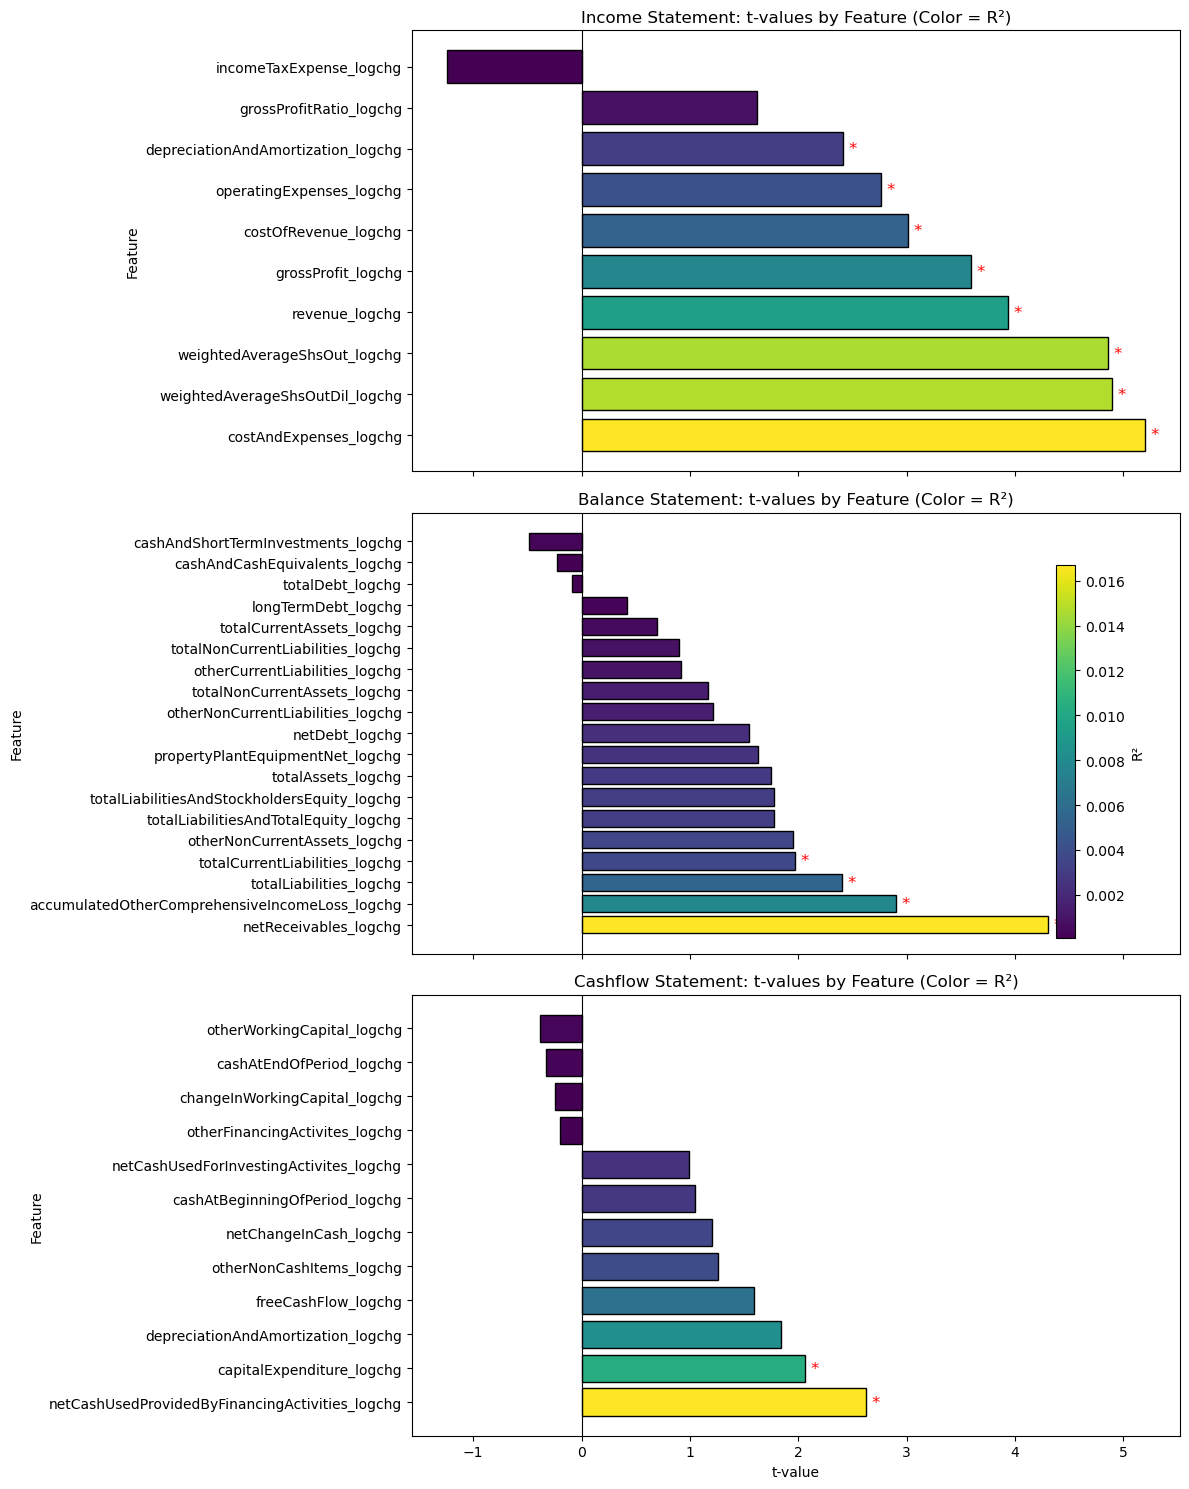

In [34]:
# Combine for convenience, but we’ll split by statement type
plot_df = pd.concat([
    uni_results_income.assign(statement_type='Income'),
    uni_results_balance.assign(statement_type='Balance'),
    uni_results_cashflow.assign(statement_type='Cashflow')
], ignore_index=True)

statement_order = ['Income', 'Balance', 'Cashflow']
n_statements = len(statement_order)

# Create subplots (one per statement type)
fig, axes = plt.subplots(n_statements, 1, figsize=(12, 5*n_statements), sharex=True)

for i, statement in enumerate(statement_order):
    ax = axes[i]
    
    # Subset for this statement
    df = plot_df[plot_df['statement_type'] == statement].copy()
    
    # Sort by absolute t-value descending
    df = df.sort_values('t_value', ascending=False).reset_index(drop=True)
    
    # Normalize r² for color mapping
    norm = mpl.colors.Normalize(vmin=df['r2'].min(), vmax=df['r2'].max())
    cmap = mpl.cm.viridis
    colors = [cmap(norm(val)) for val in df['r2']]
    
    # Y positions
    y_pos = range(len(df))
    
    # Horizontal bar chart
    ax.barh(y=y_pos, width=df['t_value'], color=colors, edgecolor='black')
    
    # Highlight significant features
    for idx, row in enumerate(df.itertuples()):
        if row.reject_null:
            ax.text(
                x=row.t_value + (0.05 if row.t_value>0 else -0.05),
                y=idx,
                s='*',
                va='center',
                ha='left' if row.t_value>0 else 'right',
                color='red',
                fontsize=12
            )
    
    # Y-axis labels
    ax.set_yticks(y_pos)
    ax.set_yticklabels(df['feature'], fontsize=10)
    ax.axvline(0, color='black', linewidth=0.8)
    ax.set_ylabel('Feature')
    ax.set_title(f'{statement} Statement: t-values by Feature (Color = R²)')

# Shared x-label
axes[-1].set_xlabel('t-value')

# Add a single colorbar
scalar_map = mpl.cm.ScalarMappable(cmap=cmap, norm=norm)
scalar_map.set_array([])
cbar = fig.colorbar(scalar_map, ax=axes, orientation='vertical', fraction=0.02, pad=0.01)
cbar.set_label('R²')


plt.tight_layout()
plt.show()


In [35]:
def select_significant_features(statement_df, uni_results, 
                                t_threshold=1.2, r2_threshold=0.005, p_threshold=0.2, 
                                label=""):
    """
    Select significant features from a financial statement dataframe
    based on univariate regression results. 
    Returns only the subset of statement_df with those features.
    """
    # Filter by thresholds
    signif = uni_results[
        (uni_results["t_value"].abs() > t_threshold) &
        (uni_results["r2"] > r2_threshold) &
        (uni_results["p_value"] < p_threshold)
    ]

    features = signif["feature"].tolist()
    
    # Only use statement data — no merge
    selected = statement_df[["symbol", "date", "symbol_date"] + features]

    if label:
        total_features = len(uni_results)
        n_selected = len(features)
        pct = (n_selected / total_features * 100) if total_features > 0 else 0
        print(f"{label.title()}: {n_selected}/{total_features} features selected ({pct:.1f}%)")

    return selected

In [36]:
print(income_after_outlier_drop.columns.tolist())

['symbol', 'date', 'revenue_logchg', 'costOfRevenue_logchg', 'grossProfit_logchg', 'grossProfitRatio_logchg', 'operatingExpenses_logchg', 'costAndExpenses_logchg', 'depreciationAndAmortization_logchg', 'incomeTaxExpense_logchg', 'weightedAverageShsOut_logchg', 'weightedAverageShsOutDil_logchg']


In [37]:
uni_results_income = uni_results_income[uni_results_income['feature'] != 'eps']
uni_results_balance = uni_results_balance[uni_results_balance['feature'] != 'eps']
uni_results_cashflow = uni_results_cashflow[uni_results_cashflow['feature'] != 'eps']

In [38]:
print(income_after_outlier_drop.shape)
print(balance_after_outlier_drop.shape)
print(cashflow_after_outlier_drop.shape)

(496, 12)
(473, 21)
(456, 14)


In [39]:
# Select significant features from each statement type
selected_income = select_significant_features(
    merged_income, uni_results_income, label="Income"
)

selected_balance = select_significant_features(
    merged_balance, uni_results_balance, label="Balance"
)

selected_cashflow = select_significant_features(
    merged_cashflow, uni_results_cashflow, label="Cashflow"
)

print(selected_income.shape)
print(selected_balance.shape)
print(selected_cashflow.shape)

Income: 9/10 features selected (90.0%)
Balance: 10/19 features selected (52.6%)
Cashflow: 4/12 features selected (33.3%)
(408, 12)
(408, 13)
(408, 7)


In [40]:
def combine_selected_features(selected_dfs, labels=None, add_prefix=True):
    """
    Combine multiple selected feature DataFrames (e.g., income, balance, cashflow)
    into one aligned DataFrame suitable for PCA.

    Parameters
    ----------
    selected_dfs : list of pd.DataFrame
        List of selected DataFrames (each with ['symbol', 'date', 'symbol_date']).
    labels : list of str or None
        Optional list of labels corresponding to each DataFrame 
        (e.g., ['income', 'balance', 'cashflow']).
    add_prefix : bool
        Whether to prefix column names with their label for clarity.

    Returns
    -------
    combined_df : pd.DataFrame
        Merged DataFrame with identifiers and all features aligned.
    """
    if labels is None:
        labels = [f"df{i+1}" for i in range(len(selected_dfs))]

    dfs_prefixed = []
    for df, label in zip(selected_dfs, labels):
        id_cols = ["symbol", "date", "symbol_date"]
        feature_cols = [c for c in df.columns if c not in id_cols]
        df_copy = df.copy()
        if add_prefix:
            df_copy = df_copy.rename(columns={c: f"{label}_{c}" for c in feature_cols})
        dfs_prefixed.append(df_copy)

    # Merge all on common keys
    combined_df = dfs_prefixed[0]
    for df in dfs_prefixed[1:]:
        combined_df = combined_df.merge(df, on=["symbol", "date", "symbol_date"], how="inner")

    return combined_df


In [41]:
combined_selected_line_items = combine_selected_features(
    [selected_income, selected_balance, selected_cashflow],
    labels=["income", "balance", "cashflow"],
    add_prefix=True
)

print(combined_selected_line_items.shape)


(408, 26)


# latent factor analysis 

In [42]:
def run_pca(df, n_components=None, prefix="PC"):
    """
    Run PCA on the numeric feature columns of a dataframe.
    Returns a separate dataframe containing only the PCA components,
    plus 'symbol' and 'date' as identifiers.

    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with ['symbol', 'date', 'symbol_date'] and features.
    n_components : int or None
        Number of PCA components. If None, use all numeric features.
    prefix : str
        Prefix for PCA component columns.

    Returns
    -------
    pca_components_df : pd.DataFrame
        Dataframe with symbol, date, and PCA components.
    pca_model : PCA object
        Fitted PCA object.
    """
    id_cols = ["symbol", "date", "symbol_date"]
    feature_cols = [c for c in df.columns if c not in id_cols]

    X = df[feature_cols].fillna(0)

    if n_components is None:
        n_components = min(len(feature_cols), len(df))

    pca = PCA(n_components=n_components)
    components = pca.fit_transform(X)

    comp_cols = [f"{prefix}{i+1}" for i in range(n_components)]
    pca_df = pd.DataFrame(components, columns=comp_cols, index=df.index)

    # Return only symbol/date/symbol_date and components
    pca_components_df = pd.concat([df[id_cols], pca_df], axis=1)

    return pca_components_df, pca


In [43]:
# Income statement PCA
income_df_pca, income_pca_model = run_pca(
    selected_income,        
    n_components=3,
    prefix="income_"
)

# Balance sheet PCA
balance_df_pca, balance_pca_model = run_pca(
    selected_balance,
    n_components=3,
    prefix="balance_"
)

# Cash flow PCA
cashflow_df_pca, cashflow_pca_model = run_pca(
    selected_cashflow,
    n_components=3,
    prefix="cashflow_"
)

In [44]:
def combine_pca_dfs(income_df_pca, balance_df_pca, cashflow_df_pca):

    # Identify ID columns and feature columns
    id_cols = ["symbol", "date", "symbol_date"]

    # Keep IDs from the first dataframe (should be identical across all)
    combined_pca_df = income_df_pca[id_cols].copy()

    # Concatenate numeric PCA features from all three
    combined_features = pd.concat([
        income_df_pca.drop(columns=id_cols),
        balance_df_pca.drop(columns=id_cols),
        cashflow_df_pca.drop(columns=id_cols)
    ], axis=1)

    # Combine identifiers with features
    combined_pca_df = pd.concat([combined_pca_df, combined_features], axis=1)

    return combined_pca_df

In [45]:
combined_pca_df = combine_pca_dfs(
    income_df_pca,
    balance_df_pca,
    cashflow_df_pca
)

print(combined_pca_df.shape)
print(combined_pca_df.columns[:10])

(408, 12)
Index(['symbol', 'date', 'symbol_date', 'income_1', 'income_2', 'income_3',
       'balance_1', 'balance_2', 'balance_3', 'cashflow_1'],
      dtype='object')


In [46]:
print(income_df_pca.columns)
print(balance_df_pca.columns)
print(cashflow_df_pca.columns)

print(income_df_pca.shape)
print(balance_df_pca.shape)
print(cashflow_df_pca.shape)

Index(['symbol', 'date', 'symbol_date', 'income_1', 'income_2', 'income_3'], dtype='object')
Index(['symbol', 'date', 'symbol_date', 'balance_1', 'balance_2', 'balance_3'], dtype='object')
Index(['symbol', 'date', 'symbol_date', 'cashflow_1', 'cashflow_2',
       'cashflow_3'],
      dtype='object')
(408, 6)
(408, 6)
(408, 6)


In [47]:
def regress_log_pe_on_pca(combined_df, pe_data_sorted, log_pe_col="log_PE"):
    """
    Run a multivariable linear regression using PCA components (already combined in `combined_df`)
    as independent variables, and the precomputed log_PE from `pe_data_sorted` as the dependent variable.

    Assumes both dataframes are already aligned on index.

    Parameters
    ----------
    combined_df : pd.DataFrame
        DataFrame containing all PCA components (independent variables).
    pe_data_sorted : pd.DataFrame
        DataFrame containing the log_PE column.
    log_pe_col : str, default "log_PE"
        Column name for the logged PE ratio in `pe_data_sorted`.

    Returns
    -------
    model : statsmodels.regression.linear_model.RegressionResultsWrapper
        Fitted OLS model.
    reg_df : pd.DataFrame
        DataFrame containing all features and the dependent variable (used in regression).
    """

    # Build regression dataframe
    reg_df = combined_df.copy()
    reg_df[log_pe_col] = pe_data_sorted[log_pe_col]

    # Replace inf/-inf with NaN and drop missing
    reg_df = reg_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Split dependent and independent variables
    y = reg_df[log_pe_col]
    X = reg_df.drop(columns=[log_pe_col]).select_dtypes(include=["number"])

    # Add constant
    X_const = sm.add_constant(X)

    # Fit regression
    model = sm.OLS(y, X_const).fit()

    print(model.summary())
    return model, reg_df


In [48]:
model, reg_df = regress_log_pe_on_pca(
    combined_pca_df,   
    pe_data_sorted,
    log_pe_col="log_PE")

                            OLS Regression Results                            
Dep. Variable:                 log_PE   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     1.624
Date:                Fri, 07 Nov 2025   Prob (F-statistic):              0.106
Time:                        13:29:40   Log-Likelihood:                -453.10
No. Observations:                 408   AIC:                             926.2
Df Residuals:                     398   BIC:                             966.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2758      0.037     88.959      0.0

In [49]:
model, reg_df = regress_log_pe_on_pca(
    combined_selected_line_items,   # your already concatenated PCA dataframe
    pe_data_sorted,
    log_pe_col="log_PE"
)

                            OLS Regression Results                            
Dep. Variable:                 log_PE   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.9822
Date:                Fri, 07 Nov 2025   Prob (F-statistic):              0.486
Time:                        13:29:40   Log-Likelihood:                -449.32
No. Observations:                 408   AIC:                             944.6
Df Residuals:                     385   BIC:                             1037.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
                                                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------